# Wasnik, Riya
# 1001-163-569
# 2017-02-07
# Assignment_01_01
 


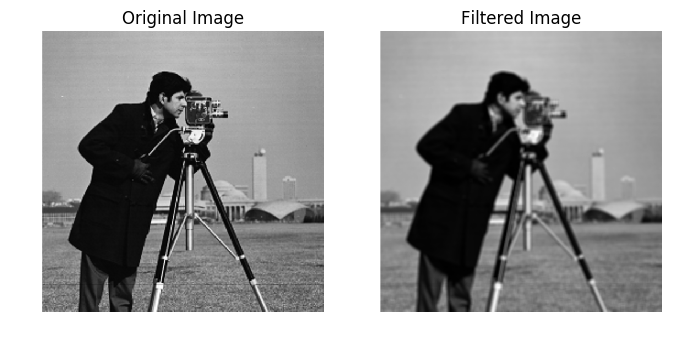

In [275]:
# Task1
from skimage import data
from ipywidgets import interact, fixed, FloatSlider, IntSlider,FloatRangeSlider, Label, Checkbox
import matplotlib.pyplot as plt
import scipy
import numpy as np

theta_degree_list =[]
cameraman_image = data.camera()/255.
processed_image = cameraman_image.copy()

def gaussian_filter_and_display_results(original_image, sigma = 5,kernel_size =7):
    kernel_size=kernel_size if kernel_size%2 else kernel_size+1
    temp_image = np.zeros((kernel_size, kernel_size))
    # set element at the middle to one
    temp_image[int(kernel_size/2), int(kernel_size/2)] = 1
    scipy.ndimage.filters.gaussian_filter(temp_image, 
            sigma=sigma, order=0, output=None, mode='reflect', cval=0.0)
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    kernel = scipy.ndimage.filters.gaussian_filter(temp_image, 
            sigma=sigma, order=0, output=None, mode='reflect', cval=0.0)
    filtered_image = scipy.ndimage.convolve(original_image, kernel)
    fig1, axes_array = plt.subplots(1, 2)
    fig1.set_size_inches(8,4)
    image_plot = axes_array[0].imshow(original_image, cmap = plt.cm.gray) 
    axes_array[0].axis('off')
    axes_array[0].set(title='Original Image')
    image_plot = axes_array[1].imshow(filtered_image,cmap=plt.cm.gray)
    axes_array[1].axis('off')
    axes_array[1].set(title='Filtered Image')
    plt.show()
    processed_image =  filtered_image.copy()  #stores the smoothed image
    
interact(gaussian_filter_and_display_results,original_image=fixed(cameraman_image),
         sigma=FloatSlider(min=0.0, max=10, step=0.1,continuous_update=False,value=5),
         kernel_size=IntSlider(min=1, max=51., step=2, continuous_update=False, value=7));

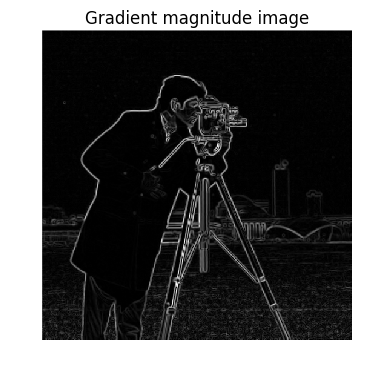

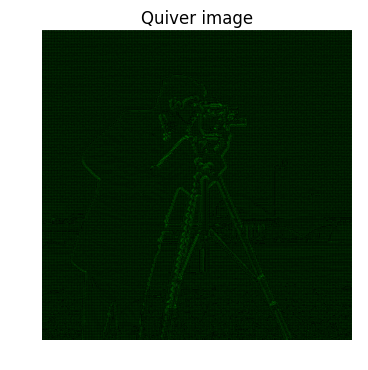

In [276]:
#Task2

#plt.rcParams['image.interpolation'] = 'none'
smoothed_image= processed_image.copy()
horizontal_kernel = np.array([[ 1.,  2,  1],[ 0,  0,  0],[-1,-2,-1]])
vertical_kernel = np.array([[ -1.,  0,  1],[ -2,  0,  2],[-1,0,1]])

 # Normalize the kernels
kernel_sum=abs(np.sum(horizontal_kernel))
horizontal_kernel= horizontal_kernel/kernel_sum if kernel_sum else horizontal_kernel
kernel_sum=abs(np.sum(vertical_kernel))
vertical_kernel= vertical_kernel/kernel_sum if kernel_sum else vertical_kernel

horizontal_edge_image = scipy.ndimage.convolve(smoothed_image, horizontal_kernel)
vertical_edge_image= scipy.ndimage.convolve(smoothed_image, vertical_kernel)
gradient_image = np.sqrt(horizontal_edge_image**2 + vertical_edge_image**2) #magnitude

theta = np.arctan2(horizontal_edge_image, vertical_edge_image)
theta_degree = np.rad2deg(theta)


plt.axis('off')
plt.title('Gradient magnitude image')
plt.imshow(gradient_image ,cmap=plt.cm.gray)
plt.figure()


x, y = np.meshgrid(np.arange(0, 512), np.arange(0, 512))
plt.imshow(gradient_image, cmap=plt.cm.gray)
plt.quiver(x, y, vertical_edge_image, horizontal_edge_image,units='width',color='g',
               linewidths=(0.2))
plt.title('Quiver image')
plt.axis('off')
plt.show()

         

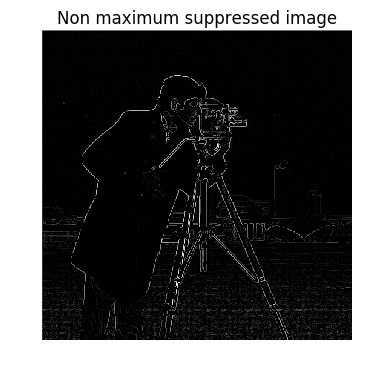

In [277]:
#Task3

#classifying angles as either 0,45,90,135
theta_degree[np.where(np.logical_or(np.logical_and(theta_degree<22.5, theta_degree>-22.5),np.logical_or(theta_degree>157.5,theta_degree<-157.5)))] = 0
theta_degree[np.where(np.logical_or(np.logical_and(theta_degree>22.5, theta_degree<67.5), np.logical_and(theta_degree<-112.5, theta_degree>-157.5)))] = 45
theta_degree[np.where(np.logical_or(np.logical_and(theta_degree>67.5, theta_degree<112.5),np.logical_and(theta_degree<-67.5, theta_degree>-112.5)))] = 90
theta_degree[np.where(np.logical_or(np.logical_and(theta_degree>112.5,theta_degree<157.5),np.logical_and(theta_degree<-22.5, theta_degree>-67.5)))] = 135


edge_image=np.zeros((512,512))

cond1= theta_degree==0
index1 = np.argwhere(cond1)
for i in index1:
    x=i[0]
    y=i[1]
    if( y <511 and y>0): # comparison with east west neighbors
        if((gradient_image[x][y]> gradient_image[x][y-1]) and (gradient_image[x][y]> gradient_image[x][y+1])):
            edge_image[x][y] = gradient_image[x][y]
            
cond2= theta_degree==90
index2 = np.argwhere(cond2)  
for i in index2:
    x=i[0]
    y=i[1]
    if(x>0 and x<511 ): # comparison with north south neighbors
        if((gradient_image[x][y]> gradient_image[x-1][y]) and (gradient_image[x][y]> gradient_image[x+1][y]) ): 
            edge_image[x][y] = gradient_image[x][y]
    
cond3= theta_degree==135
index3 = np.argwhere(cond3)    
for i in index3:
    x=i[0]
    y=i[1]
    if(x>0 and y>0 and x<511 and y<511): # comparison with north-west south-east
        if((gradient_image[x][y]> gradient_image[x-1][y-1]) and (gradient_image[x][y]> gradient_image[x+1][y+1])):
            edge_image[x][y] = gradient_image[x][y]
           
        
cond4= theta_degree==45
index4 = np.argwhere(cond4)    
for i in index4:
    x=i[0]
    y=i[1]
    if(x>0 and y>0 and x<511 and y<511):  #north east and south west
        if((gradient_image[x][y]> gradient_image[x-1][y+1]) and (gradient_image[x][y]> gradient_image[x+1][y-1])):
            edge_image[x][y] = gradient_image[x][y]

plt.axis('off')
plt.title('Non maximum suppressed image')
plt.imshow(edge_image ,cmap=plt.cm.gray)
plt.show()


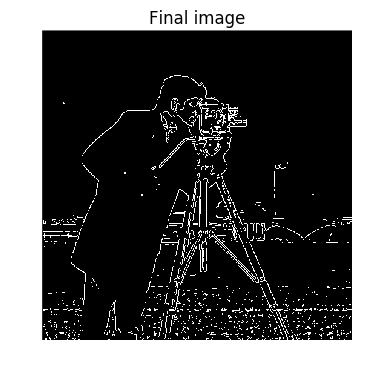

In [278]:
#Task4
final_image=np.zeros((512,512))
def double_threshold(low_threshold =0.5,high_threshold =2.5):
    strong_edge_pixel = edge_image > high_threshold
    final_image[strong_edge_pixel] = 1 #strong_edge_pixels are a part of the edge
    weak_edge_pixel = (edge_image >= low_threshold) & (edge_image <= high_threshold)
    index_weak_edge_pixel = np.argwhere(weak_edge_pixel)
    
    for i in index_weak_edge_pixel:
        x=i[0]
        y=i[1]
        if(x>0 and y>0 and x<511 and y<511):
            north = edge_image[x-1][y]
            south = edge_image[x+1][y]
            east = edge_image[x][y+1]
            west = edge_image[x][y-1]
            north_east = edge_image[x-1][y+1]
            north_west = edge_image[x-1][y-1]
            south_west = edge_image[x+1][y-1]
            south_east = edge_image[x+1][y+1]
            #check if any of the 8 neighbors is a strong edge pixel
            if((north in strong_edge_pixel) or (south in strong_edge_pixel) or (east in strong_edge_pixel) or (west in strong_edge_pixel)
               or (north_east in strong_edge_pixel)or (north_west in strong_edge_pixel)  or (south_east in strong_edge_pixel) or
               (south_west in strong_edge_pixel)):
                final_image[x][y] = 1  # classify the pixel as an edge pixel
               
   
    plt.imshow(final_image ,cmap=plt.cm.gray) 
    plt.axis('off')
    plt.title('Final image')
    plt.show()

interact(double_threshold, low_threshold=FloatSlider(min=0.0, max=1.5, step=0.1,continuous_update=False,value=0.5),
         high_threshold=FloatSlider(min=1.6, max=5., step=0.1,continuous_update=False,value=2.5));